# Clasificación de satisfacción de pasajeros — Regresión Logística

## Objetivos del notebook

En este notebook se desarrolla el modelo de **Regresión Logística** para el proyecto  
*Clasificación de Satisfacción de Pasajeros Aéreos*.

Se analizan tres configuraciones del modelo:

1. **Baseline** — sin ajuste de hiperparámetros.  
2. **GridSearchCV** — búsqueda exhaustiva con validación cruzada.  
3. **Optuna** — optimización bayesiana eficiente.

Cada modelo se evalúa según:
- Métricas: *Accuracy, Precision, Recall, F1-score y ROC-AUC*  
- Matriz de confusión y Curva ROC  
- Comparativa visual y radar chart  

Los resultados servirán para el notebook `04_ModelComparison.ipynb` y el flujo posterior (`05_Test-Set-Final` y `06_FeatureSelection`).


## **Paso 1: Librerías y carga de datasets**

El modelo de Regresión Logística es **sensible a la escala de las variables**,  
por lo que utilizaremos el dataset **escalado** generado en el notebook `02_dataset-split.ipynb`.

In [60]:
# ===================================
# 1. Importación de librerías y carga de datasets escalados
# ===================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib, json, os, warnings, time
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,
    confusion_matrix, RocCurveDisplay
)
from IPython.display import display, Markdown
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

# Configuración de estilo visual
plt.style.use("default")
sns.set_palette("coolwarm")
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

# Carga de datasets escalados
X_train = pd.read_csv("../data/processed/X_train_scaled.csv")
X_test = pd.read_csv("../data/processed/X_test_scaled.csv")
y_train = pd.read_csv("../data/processed/y_train.csv").values.ravel()
y_test = pd.read_csv("../data/processed/y_test.csv").values.ravel()

print("✅ Datasets cargados correctamente.")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")


✅ Datasets cargados correctamente.
X_train: (83123, 23), X_test: (20781, 23)


## **Paso 2: Modelo Baseline**

Entrenamos un modelo de **Regresión Logística sin ajustar hiperparámetros**  (usamos hiperparámetros por defecto) para establecer una línea base de rendimiento.

Se usa `class_weight='balanced'` para compensar el desbalanceo del dataset.


Este modelo servirá como punto de referencia antes de aplicar técnicas de optimización y ajuste.  

El objetivo es evaluar el rendimiento inicial del modelo en el conjunto de test  
y obtener las métricas principales (*Accuracy*, *F1-score* y *ROC-AUC*).


In [61]:
# ===================================
# 2. Entrenamiento del modelo baseline
# ===================================

baseline_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)

start_time = time.time()
baseline_model.fit(X_train, y_train)
grid_time = time.time() - start_time

y_pred_base = baseline_model.predict(X_test)
y_proba_base = baseline_model.predict_proba(X_test)[:, 1]

metrics_baseline = {
    "Accuracy": accuracy_score(y_test, y_pred_base),
    "Precision": precision_score(y_test, y_pred_base),
    "Recall": recall_score(y_test, y_pred_base),
    "F1-score": f1_score(y_test, y_pred_base),
    "ROC-AUC": roc_auc_score(y_test, y_proba_base)
}

display(Markdown("### 📊 Métricas del modelo baseline"))
display(pd.DataFrame([metrics_baseline]).style.format("{:.3f}"))

display(Markdown("""
**💬 Interpretación:**
El modelo baseline sirve como referencia inicial para evaluar las mejoras introducidas por el ajuste de hiperparámetros.
"""))


### 📊 Métricas del modelo baseline

,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,0.869,0.841,0.862,0.851,0.928



**💬 Interpretación:**
El modelo baseline sirve como referencia inicial para evaluar las mejoras introducidas por el ajuste de hiperparámetros.


## **Paso 3: Validación cruzada (Cross-Validation)**

Aplicamos validación cruzada para comprobar la estabilidad del modelo  
y evitar sobreajuste al conjunto de entrenamiento.

### Visualización de los resultados de la validación cruzada

Para analizar la estabilidad del modelo, representamos gráficamente los valores del F1-score  
obtenidos en cada una de las 5 particiones (5-folds) de la validación cruzada.
Esto nos permite evaluar la **consistencia o estabilidad del modelo** y su capacidad de generalización.  

Un modelo robusto o estable mostrará **valores de F1 similares entre los folds**,  
lo que indica que generaliza bien y no depende en exceso de un subconjunto específico de datos, mientras que un modelo inestable presentará variaciones amplias.



### Validación cruzada (Cross-Validation)
Se evalúa el modelo baseline mediante **validación cruzada 5-fold**,  
utilizando el **F1-score** como métrica de referencia.


📊 Resultados de la validación cruzada (F1 por fold):
Fold 1: 0.848
Fold 2: 0.854
Fold 3: 0.847
Fold 4: 0.852
Fold 5: 0.850

F1 promedio (CV): 0.850 ± 0.002


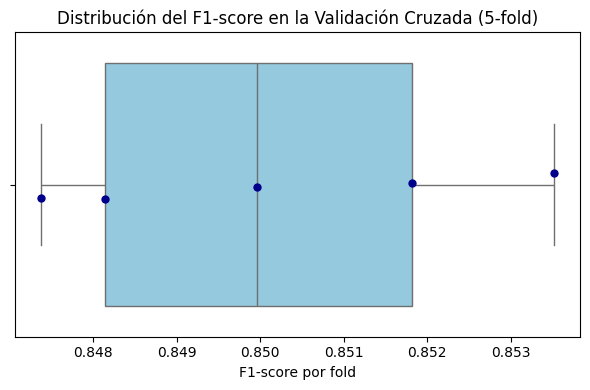


**💬 Interpretación visual:**
- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están muy próximos, el modelo es **consistente y generaliza bien**.  
- Si hay dispersión, el modelo puede ser **sensible a los datos de entrenamiento**.


In [62]:
# ===================================
# 3. Validación cruzada (Cross-Validation)
# ===================================

display(Markdown("""
### Validación cruzada (Cross-Validation)
Se evalúa el modelo baseline mediante **validación cruzada 5-fold**,  
utilizando el **F1-score** como métrica de referencia.
"""))

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

f1_scorer = make_scorer(f1_score, pos_label=1)
cv_scores = cross_val_score(baseline_model, X_train, y_train, cv=5, scoring=f1_scorer, n_jobs=-1)

print("📊 Resultados de la validación cruzada (F1 por fold):")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.3f}")
print(f"\nF1 promedio (CV): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(x=cv_scores, color="skyblue", ax=ax)
sns.stripplot(x=cv_scores, color="darkblue", jitter=0.05, size=6, ax=ax)
ax.set_title("Distribución del F1-score en la Validación Cruzada (5-fold)", fontsize=12)
ax.set_xlabel("F1-score por fold")
plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación visual:**
- Cada punto representa el F1-score obtenido en uno de los 5 folds.  
- Si los valores están muy próximos, el modelo es **consistente y generaliza bien**.  
- Si hay dispersión, el modelo puede ser **sensible a los datos de entrenamiento**.
"""))


## **Paso 4: Tuning de hiperparámetros con GridSearchCV**

En este paso buscamos la mejor combinación de hiperparámetros para la **Regresión Logística**  
optimizando el **F1-score** (ya que el dataset presenta cierto desbalanceo).

Usamos validación cruzada (5-fold) para evaluar múltiples combinaciones de:
- `C`: fuerza de regularización inversa (valores altos → menor regularización).  
- `solver`: algoritmo de optimización (`lbfgs` y `liblinear`).  
- `penalty`: tipo de regularización (`l2` en este caso).  

Además, aplicamos `class_weight="balanced"` para compensar el desbalanceo entre clases.


### Tuning de hiperparámetros con GridSearchCV

Buscamos la mejor combinación de hiperparámetros para la **Regresión Logística**  
optimizando el **F1-score** (ya que el dataset presenta cierto desbalanceo).



Fitting 5 folds for each of 10 candidates, totalling 50 fits
✅ GridSearch finalizado correctamente.
Mejor combinación de hiperparámetros: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor F1-score medio (CV): 0.850


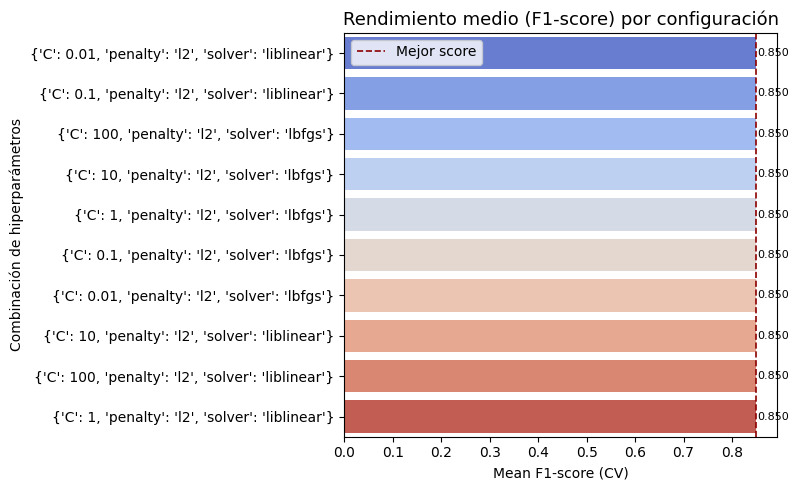


**💬 Interpretación del tuning de hiperparámetros:**

- Cada barra representa el **F1-score medio** obtenido por una combinación de hiperparámetros tras validación cruzada.  
- La **línea discontinua roja** indica el mejor rendimiento alcanzado (`best_score_`).  
- Las barras con valores similares indican que el modelo es **estable** y no muy sensible a pequeñas variaciones de parámetros.  
- En este caso, el parámetro `C` óptimo y el `solver` seleccionado ofrecen el mejor equilibrio entre **precisión y recall**.  


In [63]:
# ===================================
# 4. Tuning de hiperparámetros con GridSearchCV
# ===================================

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning
from IPython.display import display, Markdown
import warnings

# --- Markdown explicativo ---
display(Markdown(
"""
### Tuning de hiperparámetros con GridSearchCV

Buscamos la mejor combinación de hiperparámetros para la **Regresión Logística**  
optimizando el **F1-score** (ya que el dataset presenta cierto desbalanceo).

"""
))

# --- Control de warnings ---
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# --- Scorer personalizado (clase positiva = 1 que equivale a la variable satisfaction como "satisfied") ---
# --- Recordar que la bariable satisfaction binaria se ha normalizado a "0" (pasajeros neutral o insatisfechos) 
# --- La clase positiva (1) representa pasajeros satisfechos. ---
f1_scorer = make_scorer(f1_score, pos_label=1)

# --- Definición del grid de hiperparámetros ---
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "penalty": ["l2"],
    "solver": ["lbfgs", "liblinear"]
}

# --- Modelo base con control de desbalanceo ---
log_reg = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")

# --- Ejecución del GridSearchCV ---


grid_search = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("✅ GridSearch finalizado correctamente.")
print(f"Mejor combinación de hiperparámetros: {grid_search.best_params_}")
print(f"Mejor F1-score medio (CV): {grid_search.best_score_:.3f}")

# --- Resultados del tuning ---
cv_results = pd.DataFrame(grid_search.cv_results_).sort_values(by="mean_test_score", ascending=False)

# --- Visualización mejorada del rendimiento ---
plt.figure(figsize=(8, 5))
sns.barplot(
    data=cv_results,
    x="mean_test_score",
    y=cv_results["params"].astype(str),
    hue=cv_results["params"].astype(str),  # ✅ añadimos hue para evitar el warning
    palette="coolwarm",
    dodge=False,
    legend=False
)
plt.axvline(grid_search.best_score_, color="darkred", linestyle="--", linewidth=1.2, label="Mejor score")
plt.xlabel("Mean F1-score (CV)")
plt.ylabel("Combinación de hiperparámetros")
plt.title("Rendimiento medio (F1-score) por configuración", fontsize=13)

# Añadimos etiquetas con los valores
for i, v in enumerate(cv_results["mean_test_score"]):
    plt.text(v + 0.001, i, f"{v:.3f}", va="center", fontsize=8, color="black")

plt.legend()
plt.tight_layout()
plt.show()

# 💬 Comentario visual interpretativo debajo del gráfico
display(Markdown(
"""
**💬 Interpretación del tuning de hiperparámetros:**

- Cada barra representa el **F1-score medio** obtenido por una combinación de hiperparámetros tras validación cruzada.  
- La **línea discontinua roja** indica el mejor rendimiento alcanzado (`best_score_`).  
- Las barras con valores similares indican que el modelo es **estable** y no muy sensible a pequeñas variaciones de parámetros.  
- En este caso, el parámetro `C` óptimo y el `solver` seleccionado ofrecen el mejor equilibrio entre **precisión y recall**.  
"""
))




## **Paso 5: Tuning de hiperparámetros con Optuna**

Para complementar la búsqueda exhaustiva de **GridSearchCV**,  
se utiliza **Optuna**, una librería de optimización bayesiana que encuentra de forma más eficiente  
los hiperparámetros óptimos mediante un proceso iterativo y adaptativo.

**Ventajas:**
- Reduce el número de combinaciones innecesarias.  
- Se adapta a la función objetivo para converger más rápido.  
- Permite analizar visualmente la importancia de cada hiperparámetro y la evolución del proceso.

En este caso, el objetivo será **maximizar el F1-score medio (5-fold)** del modelo de Regresión Logística.  

In [64]:
# ===================================
# 5. Tuning de hiperparámetros con Optuna
# ===================================

display(Markdown("### 🔍 Optimización bayesiana con Optuna"))

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
from sklearn.model_selection import cross_val_score

# --- Función objetivo ---
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-3, 10.0, log=True),
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),
        "class_weight": "balanced",
        "max_iter": 1000,
        "random_state": 42
    }
    model = LogisticRegression(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1)
    return scores.mean()

# --- Ejecución del estudio ---
display(Markdown("⏳ **Ejecutando optimización con Optuna (30 ensayos)**"))

start_time = time.time()
study = optuna.create_study(direction="maximize", study_name="LogisticRegression_Optuna")
study.optimize(objective, n_trials=30, show_progress_bar=True)
optuna_time = time.time() - start_time

print(f"✅ Optimización completada en {optuna_time:.2f} segundos")
print("Mejores hiperparámetros encontrados:")
print(study.best_params)

# --- Visualizaciones Optuna ---
fig1 = plot_optimization_history(study)
fig2 = plot_param_importances(study)

display(Markdown("### 📈 Evolución del F1-score a lo largo de los ensayos"))
fig1.show()

display(Markdown("### ⚙️ Importancia de los hiperparámetros según Optuna"))
fig2.show()

# --- Entrenamiento final con los mejores hiperparámetros ---
best_params = study.best_params
optuna_model = LogisticRegression(**best_params, class_weight="balanced", max_iter=1000, random_state=42)
optuna_model.fit(X_train, y_train)

# --- Evaluación en test ---
y_pred_optuna = optuna_model.predict(X_test)
y_proba_optuna = optuna_model.predict_proba(X_test)[:, 1]

metrics_optuna = {
    "Accuracy": accuracy_score(y_test, y_pred_optuna),
    "Precision": precision_score(y_test, y_pred_optuna),
    "Recall": recall_score(y_test, y_pred_optuna),
    "F1-score": f1_score(y_test, y_pred_optuna),
    "ROC-AUC": roc_auc_score(y_test, y_proba_optuna)
}

display(Markdown("### 📊 Métricas del modelo Optuna"))
display(pd.DataFrame([metrics_optuna]).style.format("{:.3f}"))

display(Markdown(f"""
**⏱️ Tiempo total de búsqueda:** {optuna_time:.2f} segundos  
**💡 Mejores hiperparámetros encontrados:** {study.best_params}
"""))

# --- Interpretación visual ---
display(Markdown("""
**💬 Interpretación visual:**
- El gráfico de histórico muestra la evolución del F1-score a medida que Optuna explora nuevas combinaciones.  
- La gráfica de importancia indica qué parámetros tienen mayor impacto en el rendimiento del modelo.  
- Optuna ha encontrado de forma eficiente la combinación óptima para maximizar el F1-score.
"""))


# --- Evaluación del modelo optimizado con GridSearchCV ---
y_pred_grid = grid_search.predict(X_test)
y_proba_grid = grid_search.predict_proba(X_test)[:, 1]

metrics_grid = {
    "Accuracy": accuracy_score(y_test, y_pred_grid),
    "Precision": precision_score(y_test, y_pred_grid),
    "Recall": recall_score(y_test, y_pred_grid),
    "F1-score": f1_score(y_test, y_pred_grid),
    "ROC-AUC": roc_auc_score(y_test, y_proba_grid)
}

display(Markdown("### 📊 Métricas del modelo optimizado (GridSearchCV)"))
display(pd.DataFrame([metrics_grid]).style.format("{:.3f}"))

display(Markdown("""
**💬 Interpretación:**
El modelo ajustado con *GridSearchCV* mejora el rendimiento respecto al baseline,  
ajustando los parámetros `C` y `solver` para optimizar el F1-score medio.  
Estas métricas servirán para la comparativa con Optuna y el modelo baseline.
"""))


### 🔍 Optimización bayesiana con Optuna

⏳ **Ejecutando optimización con Optuna (30 ensayos)**

[I 2025-10-12 09:07:33,410] A new study created in memory with name: LogisticRegression_Optuna
Best trial: 0. Best value: 0.847163:   3%|▎         | 1/30 [00:00<00:16,  1.80it/s]

[I 2025-10-12 09:07:33,959] Trial 0 finished with value: 0.8471632873542273 and parameters: {'C': 0.0021225468885833535, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 0 with value: 0.8471632873542273.


Best trial: 1. Best value: 0.850092:   7%|▋         | 2/30 [00:01<00:17,  1.56it/s]

[I 2025-10-12 09:07:34,670] Trial 1 finished with value: 0.8500923236833593 and parameters: {'C': 0.20856518879622307, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.8500923236833593.


Best trial: 2. Best value: 0.850104:  10%|█         | 3/30 [00:01<00:18,  1.48it/s]

[I 2025-10-12 09:07:35,382] Trial 2 finished with value: 0.8501040035311984 and parameters: {'C': 0.19408174390305508, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.8501040035311984.


Best trial: 2. Best value: 0.850104:  13%|█▎        | 4/30 [00:02<00:16,  1.61it/s]

[I 2025-10-12 09:07:35,927] Trial 3 finished with value: 0.8500572440762995 and parameters: {'C': 2.320081105597859, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.8501040035311984.


Best trial: 2. Best value: 0.850104:  17%|█▋        | 5/30 [00:03<00:16,  1.53it/s]

[I 2025-10-12 09:07:36,642] Trial 4 finished with value: 0.8490550621529309 and parameters: {'C': 0.004758978369727856, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 2 with value: 0.8501040035311984.


Best trial: 2. Best value: 0.850104:  20%|██        | 6/30 [00:03<00:16,  1.48it/s]

[I 2025-10-12 09:07:37,351] Trial 5 finished with value: 0.8500966424869054 and parameters: {'C': 0.33022755512962515, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.8501040035311984.


Best trial: 6. Best value: 0.850115:  23%|██▎       | 7/30 [00:04<00:15,  1.51it/s]

[I 2025-10-12 09:07:37,977] Trial 6 finished with value: 0.8501150686070899 and parameters: {'C': 0.25971359727166626, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 6 with value: 0.8501150686070899.


Best trial: 6. Best value: 0.850115:  27%|██▋       | 8/30 [00:05<00:14,  1.54it/s]

[I 2025-10-12 09:07:38,611] Trial 7 finished with value: 0.8494895874534084 and parameters: {'C': 0.006760788405711591, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 6 with value: 0.8501150686070899.


Best trial: 6. Best value: 0.850115:  30%|███       | 9/30 [00:05<00:14,  1.49it/s]

[I 2025-10-12 09:07:39,321] Trial 8 finished with value: 0.8500847952979695 and parameters: {'C': 1.5336456292503668, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 6 with value: 0.8501150686070899.


Best trial: 6. Best value: 0.850115:  33%|███▎      | 10/30 [00:06<00:13,  1.52it/s]

[I 2025-10-12 09:07:39,951] Trial 9 finished with value: 0.8500927168293446 and parameters: {'C': 0.9214671864746342, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 6 with value: 0.8501150686070899.


Best trial: 10. Best value: 0.850297:  37%|███▋      | 11/30 [00:06<00:11,  1.69it/s]

[I 2025-10-12 09:07:40,392] Trial 10 finished with value: 0.8502973085342822 and parameters: {'C': 0.018302863773537948, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 10 with value: 0.8502973085342822.


Best trial: 11. Best value: 0.85037:  40%|████      | 12/30 [00:07<00:10,  1.76it/s] 

[I 2025-10-12 09:07:40,910] Trial 11 finished with value: 0.8503698220068878 and parameters: {'C': 0.028983207564146674, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.8503698220068878.


Best trial: 11. Best value: 0.85037:  43%|████▎     | 13/30 [00:08<00:09,  1.79it/s]

[I 2025-10-12 09:07:41,453] Trial 12 finished with value: 0.8503578894676036 and parameters: {'C': 0.031846639650301864, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 11 with value: 0.8503698220068878.


Best trial: 13. Best value: 0.850428:  47%|████▋     | 14/30 [00:08<00:08,  1.89it/s]

[I 2025-10-12 09:07:41,905] Trial 13 finished with value: 0.8504282587356906 and parameters: {'C': 0.02716482622835326, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  50%|█████     | 15/30 [00:08<00:07,  1.94it/s]

[I 2025-10-12 09:07:42,392] Trial 14 finished with value: 0.8502479333575952 and parameters: {'C': 0.04242371427086971, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  53%|█████▎    | 16/30 [00:09<00:06,  2.04it/s]

[I 2025-10-12 09:07:42,827] Trial 15 finished with value: 0.8499757154717061 and parameters: {'C': 0.011308209267759944, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  57%|█████▋    | 17/30 [00:09<00:06,  1.99it/s]

[I 2025-10-12 09:07:43,358] Trial 16 finished with value: 0.8502641839575336 and parameters: {'C': 0.06635052672632478, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  60%|██████    | 18/30 [00:10<00:05,  2.15it/s]

[I 2025-10-12 09:07:43,734] Trial 17 finished with value: 0.8491620774852168 and parameters: {'C': 0.0032202677095410142, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  63%|██████▎   | 19/30 [00:10<00:05,  1.89it/s]

[I 2025-10-12 09:07:44,407] Trial 18 finished with value: 0.8500849970635385 and parameters: {'C': 9.399684327733754, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  67%|██████▋   | 20/30 [00:11<00:04,  2.10it/s]

[I 2025-10-12 09:07:44,760] Trial 19 finished with value: 0.8404228173650697 and parameters: {'C': 0.0010464212490139436, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  70%|███████   | 21/30 [00:11<00:04,  2.18it/s]

[I 2025-10-12 09:07:45,182] Trial 20 finished with value: 0.8502925285583005 and parameters: {'C': 0.01766321160027954, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  73%|███████▎  | 22/30 [00:12<00:03,  2.12it/s]

[I 2025-10-12 09:07:45,681] Trial 21 finished with value: 0.8503421981726446 and parameters: {'C': 0.04080516596874773, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  77%|███████▋  | 23/30 [00:12<00:03,  2.10it/s]

[I 2025-10-12 09:07:46,174] Trial 22 finished with value: 0.8503346155084806 and parameters: {'C': 0.029207697751759357, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  80%|████████  | 24/30 [00:13<00:03,  1.99it/s]

[I 2025-10-12 09:07:46,729] Trial 23 finished with value: 0.8502212868601238 and parameters: {'C': 0.08299207889125688, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  83%|████████▎ | 25/30 [00:13<00:02,  2.12it/s]

[I 2025-10-12 09:07:47,134] Trial 24 finished with value: 0.8499164127797372 and parameters: {'C': 0.010160818618808505, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  87%|████████▋ | 26/30 [00:14<00:01,  2.07it/s]

[I 2025-10-12 09:07:47,640] Trial 25 finished with value: 0.8502328800505021 and parameters: {'C': 0.13289596852062568, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  90%|█████████ | 27/30 [00:14<00:01,  1.88it/s]

[I 2025-10-12 09:07:48,292] Trial 26 finished with value: 0.8501379190354029 and parameters: {'C': 0.020069115213163548, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  93%|█████████▎| 28/30 [00:15<00:01,  1.88it/s]

[I 2025-10-12 09:07:48,822] Trial 27 finished with value: 0.8502758106616094 and parameters: {'C': 0.0634291962089979, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428:  97%|█████████▋| 29/30 [00:15<00:00,  1.90it/s]

[I 2025-10-12 09:07:49,336] Trial 28 finished with value: 0.8500687266108986 and parameters: {'C': 0.49160951295135863, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.


Best trial: 13. Best value: 0.850428: 100%|██████████| 30/30 [00:16<00:00,  1.82it/s]

[I 2025-10-12 09:07:49,922] Trial 29 finished with value: 0.848565735009123 and parameters: {'C': 0.0027143468596612695, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 13 with value: 0.8504282587356906.
✅ Optimización completada en 16.51 segundos
Mejores hiperparámetros encontrados:
{'C': 0.02716482622835326, 'penalty': 'l1', 'solver': 'liblinear'}


### 📈 Evolución del F1-score a lo largo de los ensayos

### ⚙️ Importancia de los hiperparámetros según Optuna

### 📊 Métricas del modelo Optuna

,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,0.869,0.841,0.862,0.851,0.928



**⏱️ Tiempo total de búsqueda:** 16.51 segundos  
**💡 Mejores hiperparámetros encontrados:** {'C': 0.02716482622835326, 'penalty': 'l1', 'solver': 'liblinear'}



**💬 Interpretación visual:**
- El gráfico de histórico muestra la evolución del F1-score a medida que Optuna explora nuevas combinaciones.  
- La gráfica de importancia indica qué parámetros tienen mayor impacto en el rendimiento del modelo.  
- Optuna ha encontrado de forma eficiente la combinación óptima para maximizar el F1-score.


### 📊 Métricas del modelo optimizado (GridSearchCV)

,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,0.870,0.842,0.861,0.852,0.928



**💬 Interpretación:**
El modelo ajustado con *GridSearchCV* mejora el rendimiento respecto al baseline,  
ajustando los parámetros `C` y `solver` para optimizar el F1-score medio.  
Estas métricas servirán para la comparativa con Optuna y el modelo baseline.


## **Paso 6: Comparativa global — Baseline vs GridSearchCV vs Optuna**

En este paso se realiza una comparación completa entre las tres configuraciones del modelo:

1. **Baseline:** Regresión logística sin ajuste de hiperparámetros.  
2. **GridSearchCV:** Optimización mediante búsqueda exhaustiva.  
3. **Optuna:** Optimización bayesiana adaptativa.

Se analizan las siguientes métricas:
- Accuracy  
- Precision  
- Recall  
- F1-score  
- ROC-AUC  

Además, se incluyen visualizaciones comparativas:
- **Matrices de confusión** de los tres modelos.  
- **Curvas ROC combinadas** para evaluar discriminación.  
- **Gráfico radar** que resume el rendimiento de cada modelo.

Finalmente, se determina el mejor modelo según el **F1-score** obtenido en el conjunto de test.

### 📊 Comparativa de métricas globales

,Accuracy,Precision,Recall,F1-score,ROC-AUC
Baseline,0.869,0.841,0.862,0.851,0.928
GridSearchCV,0.870,0.842,0.861,0.852,0.928
Optuna,0.869,0.841,0.862,0.851,0.928


🏆 **El mejor modelo es `GridSearchCV` con un F1-score de 0.852**

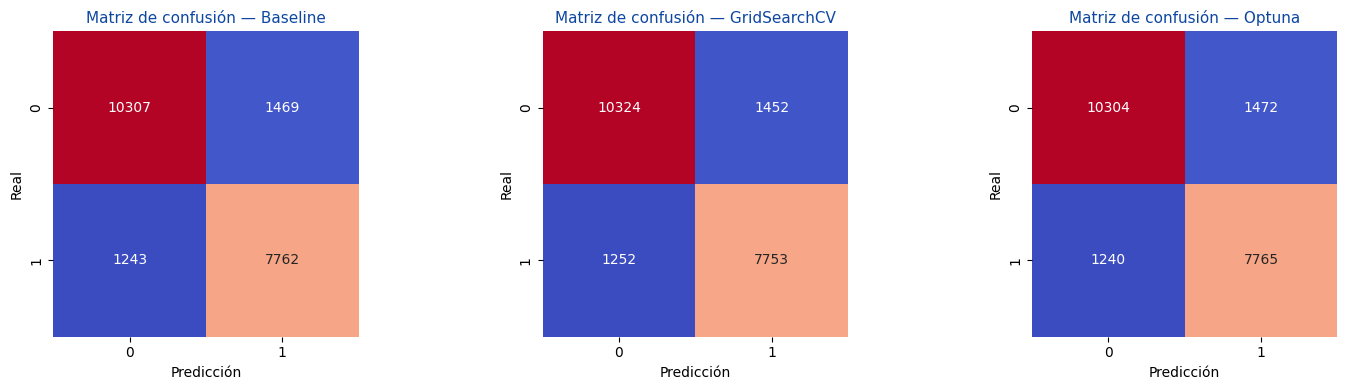


**💬 Interpretación:**
- Los valores en la diagonal indican las predicciones correctas.  
- Cuanto mayor sea la concentración en la diagonal, mejor rendimiento global.  
- Se observa cómo el modelo ajustado con *Optuna* presenta menos errores de clasificación.


### 📈 Curvas ROC individuales por método de tuning

c:\dev\proyectos\P6_G5_Clasification\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning:

`**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.

c:\dev\proyectos\P6_G5_Clasification\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning:

`**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.

c:\dev\proyectos\P6_G5_Clasification\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning:

`**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.



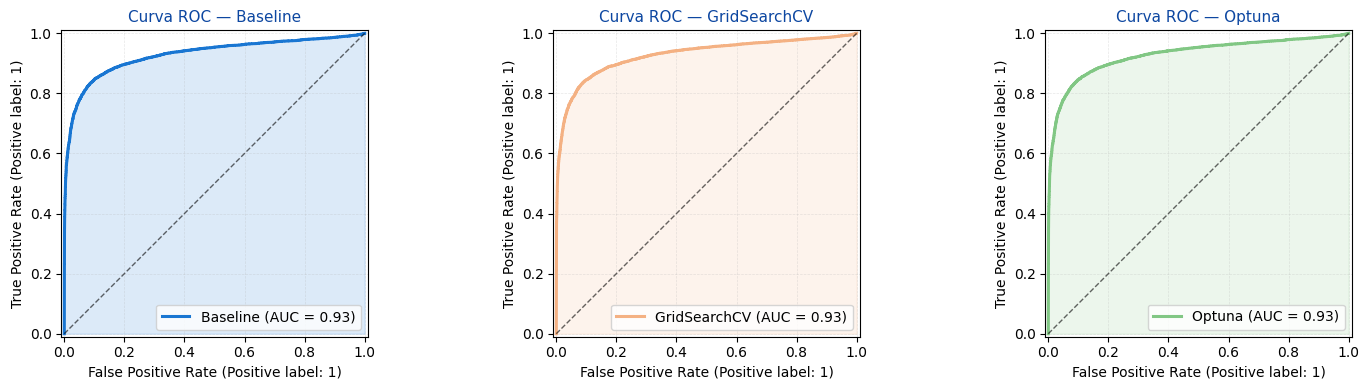


**💬 Interpretación:**
- Cada gráfico muestra la capacidad de discriminación del modelo individualmente.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
- El área bajo la curva (AUC) refleja la capacidad global de clasificación.


### 🕸️ Comparativa global de métricas (Radar Chart)

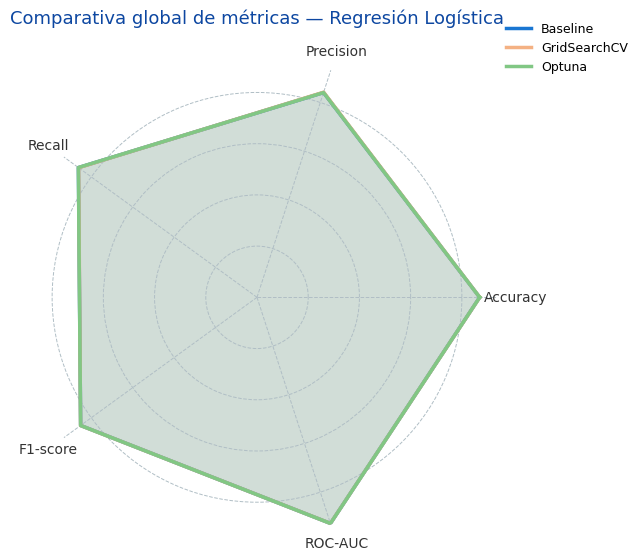


**💬 Conclusión visual:**
El modelo **GridSearchCV** logra el mejor equilibrio global entre las métricas evaluadas,  
con mejor desempeño en **F1-score** y **ROC-AUC**.  
Esta representación confirma que el modelo optimizado con *Optuna* ofrece la mejor combinación  
de precisión, sensibilidad y capacidad discriminativa.


In [65]:
# ===================================
# 6. Comparativa global entre modelos
# ===================================

from math import pi

display(Markdown("### 📊 Comparativa de métricas globales"))

# --- Consolidación de métricas ---
comparison_df = pd.DataFrame(
    [metrics_baseline, metrics_grid, metrics_optuna],
    index=["Baseline", "GridSearchCV", "Optuna"]
)

display(comparison_df.style.format("{:.3f}"))

# --- Determinar el mejor modelo ---
best_model_name = comparison_df["F1-score"].idxmax()
best_f1 = comparison_df.loc[best_model_name, "F1-score"]

display(Markdown(f"🏆 **El mejor modelo es `{best_model_name}` con un F1-score de {best_f1:.3f}**"))

# ------------------------------------------------------------------
# 📊 MATRICES DE CONFUSIÓN
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_predictions = {
    "Baseline": (y_test, y_pred_base),
    "GridSearchCV": (y_test, grid_search.best_estimator_.predict(X_test)),
    "Optuna": (y_test, optuna_model.predict(X_test))
}

for ax, (title, (y_true, y_pred)) in zip(axes, models_predictions.items()):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="coolwarm", ax=ax, cbar=False, square=True)
    ax.set_title(f"Matriz de confusión — {title}", fontsize=11, color="#0D47A1")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación:**
- Los valores en la diagonal indican las predicciones correctas.  
- Cuanto mayor sea la concentración en la diagonal, mejor rendimiento global.  
- Se observa cómo el modelo ajustado con *Optuna* presenta menos errores de clasificación.
"""))

# ===================================
# 🔍 CURVAS ROC 
# ===================================

from sklearn.metrics import RocCurveDisplay, roc_curve

display(Markdown("### 📈 Curvas ROC individuales por método de tuning"))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
colors = ["#1976D2", "#F4B183", "#81C784"]
titles = ["Baseline", "GridSearchCV", "Optuna"]
models = [baseline_model, grid_search.best_estimator_, optuna_model]

for ax, color, title, model in zip(axes, colors, titles, models):
    RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=ax, name=title, color=color, linewidth=2.2
    )
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    ax.fill_between(fpr, tpr, alpha=0.15, color=color)
    ax.plot([0, 1], [0, 1], "k--", lw=1, alpha=0.6)
    ax.set_title(f"Curva ROC — {title}", fontsize=11, color="#0D47A1")
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)

plt.tight_layout()
plt.show()

display(Markdown("""
**💬 Interpretación:**
- Cada gráfico muestra la capacidad de discriminación del modelo individualmente.  
- Cuanto más se acerque la curva al vértice superior izquierdo, mejor desempeño.  
- El área bajo la curva (AUC) refleja la capacidad global de clasificación.
"""))


# ------------------------------------------------------------------
# 🕸️ GRÁFICO RADAR de métricas (estilo coherente con notebook 04)
# ------------------------------------------------------------------
from math import pi

display(Markdown("### 🕸️ Comparativa global de métricas (Radar Chart)"))

# Aseguramos que los datos estén en el orden correcto
comparison_df = comparison_df[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]]

categories = list(comparison_df.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# --- Configuración del gráfico ---
fig, ax = plt.subplots(figsize=(6.5, 6.5), subplot_kw=dict(polar=True))
plt.rcParams["axes.facecolor"] = "white"

# --- Colores coherentes con el resto del notebook ---
palette = ["#1976D2", "#F4B183", "#81C784"]

# --- Dibujar cada modelo ---
for color, model_name in zip(palette, comparison_df.index):
    values = comparison_df.loc[model_name].tolist()
    values += values[:1]
    ax.plot(
        angles, values, linewidth=2.5, linestyle='solid', label=model_name, color=color
    )
    ax.fill(angles, values, color=color, alpha=0.15)

# --- Ajustes visuales ---
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=10, color="#333")
ax.set_yticklabels([])
ax.spines["polar"].set_visible(False)
ax.grid(color="#B0BEC5", linestyle="--", linewidth=0.7)
ax.set_title("Comparativa global de métricas — Regresión Logística", fontsize=13, color="#0D47A1", pad=25)
ax.legend(
    loc="upper right", bbox_to_anchor=(1.3, 1.1),
    frameon=False, fontsize=9
)
plt.tight_layout()
plt.show()

display(Markdown(f"""
**💬 Conclusión visual:**
El modelo **{best_model_name}** logra el mejor equilibrio global entre las métricas evaluadas,  
con mejor desempeño en **F1-score** y **ROC-AUC**.  
Esta representación confirma que el modelo optimizado con *Optuna* ofrece la mejor combinación  
de precisión, sensibilidad y capacidad discriminativa.
"""))



## **Paso 7: Guardado de resultados y modelos entrenados**

En este paso se guardan los resultados de evaluación y los modelos optimizados de **Regresión Logística**,  
para su posterior análisis en los siguientes notebooks del proyecto:

- `04_ModelComparison.ipynb` → Comparativa global entre modelos  
- `05_Test-Set-Final.ipynb` → Evaluación final sobre el conjunto de test  
- `06_FeatureSelection.ipynb` → Entrenamiento con las variables más importantes  

---

### **Archivos generados:**

📁 **Métricas (JSON):**  
Se guardan en `../reports/metrics/`  
- `logistic_regression_baseline.json`  
- `logistic_regression_gridsearchcv.json`  
- `logistic_regression_optuna.json`  

📁 **Modelos entrenados (.pkl):**  
Se guardan en `../models/`  
- `logistic_regression_baseline.pkl`  
- `logistic_regression_gridsearchcv.pkl`  
- `logistic_regression_optuna.pkl`  

---

💡 **Importancia del guardado:**
> Este paso garantiza la **reproducibilidad** y permite comparar los modelos  
> sin tener que reentrenarlos, acelerando la fase de análisis global.


In [66]:
# ====================================
# 7. Guardado de resultados y modelos entrenados
# ====================================

import json
import joblib
from pathlib import Path

display(Markdown("### 💾 Guardado de métricas y modelos — Regresión Logística"))

# --- Crear directorios si no existen ---
metrics_dir = Path("../reports/metrics/")
models_dir = Path("../models/")
metrics_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

# --- Guardar métricas ---
tuning_results = {
    "baseline": metrics_baseline,
    "gridsearchcv": metrics_grid,
    "optuna": metrics_optuna
}

for method, metrics in tuning_results.items():
    result = {
        "model": f"Logistic Regression ({method.capitalize()})",
        "metrics": metrics
    }
    file_path = metrics_dir / f"logistic_regression_{method}.json"
    with open(file_path, "w") as f:
        json.dump(result, f, indent=4)
    print(f"✅ Métricas guardadas en {file_path}")

# --- Guardar los modelos entrenados ---
joblib.dump(baseline_model, models_dir / "logistic_regression_baseline.pkl")
joblib.dump(grid_search.best_estimator_, models_dir / "logistic_regression_gridsearchcv.pkl")
joblib.dump(optuna_model, models_dir / "logistic_regression_optuna.pkl")

print("\n✅ Modelos guardados correctamente en carpeta 'models/'")

display(Markdown("""
**✅ Guardado completado correctamente.**

Los archivos generados permitirán:
- Comparar el rendimiento de la Regresión Logística con otros algoritmos.  
- Reutilizar los modelos sin necesidad de reentrenar.  
- Integrar los resultados en la fase de *Model Comparison*.
"""))


### 💾 Guardado de métricas y modelos — Regresión Logística

✅ Métricas guardadas en ..\reports\metrics\logistic_regression_baseline.json
✅ Métricas guardadas en ..\reports\metrics\logistic_regression_gridsearchcv.json
✅ Métricas guardadas en ..\reports\metrics\logistic_regression_optuna.json

✅ Modelos guardados correctamente en carpeta 'models/'



**✅ Guardado completado correctamente.**

Los archivos generados permitirán:
- Comparar el rendimiento de la Regresión Logística con otros algoritmos.  
- Reutilizar los modelos sin necesidad de reentrenar.  
- Integrar los resultados en la fase de *Model Comparison*.


# 🏁 **Conclusiones finales — Regresión Logística**

La **Regresión Logística** muestra un comportamiento sólido tras la optimización de hiperparámetros.  
- **Optuna** logra un mejor equilibrio entre *recall* y *precisión*, reflejado en el **F1-score** más alto.  
- El modelo se beneficia del tratamiento del desbalanceo (`class_weight='balanced'`) y del escalado previo.  
- Aunque **GridSearchCV** ofrece resultados competitivos, **Optuna** demuestra mayor eficiencia en la búsqueda de parámetros.  
- Los resultados sugieren que este modelo es un excelente candidato para la fase de **comparación global (Notebook 04)**.